# Tutorial for using stagewiseNN

TODO:
    Add some descriptions

In [1]:
import os
import sys
from pathlib import Path
from typing import Sequence, Mapping, Optional, Union, Callable
import logging
import pandas as pd
import numpy as np
import scanpy as sc

# if the package is not installed, you can also import it by 
ROOT = Path('../')  
sys.path.append(str(ROOT))

import swnn
from swnn import describe_dataframe, set_adata_hvgs, change_names

In [4]:
DATADIR = ROOT / 'sample_data'
os.listdir(DATADIR)

['cluster_assign.txt',
 'data_description-formed.txt',
 'hvg_frequencies.csv',
 'lineage_colors.csv',
 'merged_adults-19624.rar',
 'merged_B-L0-0.2.rar',
 'merged_B-L0-raw.h5ad',
 'merged_B-L0-raw.rar',
 'subsampled_B-L0-0.2.h5ad',
 'subsampled_B-L0-0.2.rar']

In [10]:
def get_adata(datadir=DATADIR, ):
    path = datadir / 'subsampled_B-L0-0.2.h5ad'
    path = datadir / 'merged_B-L0-raw.h5ad'
    adata = sc.read_h5ad(path)
    return adata


def get_high_freq_hvgs(min_freq=3, datadir=DATADIR):
    hvg_freq = pd.read_csv(
        datadir / 'hvg_frequencies.csv', index_col=0, header=None)
    hvg_freq = hvg_freq.iloc[:, 0]
    return hvg_freq[hvg_freq >= min_freq].index.tolist()


def formulate_adata(adata, save_path=None):
    adata.obs.columns = change_names(
        adata.obs.columns, stage='stage_id', )
    adata.obs['lineage'] = change_names(
        adata.obs['lineage'],
        {'Tail bud stem cells': 'Unassigned'}
    )
    adata.obs['stage_primer'] = adata.obs[['stage_name', 'primer']].apply(
        lambda x: '_'.join(x), axis=1
    )
    adata.obs['stagewise_cluster'] = adata.obs[['stage_name', 'leiden_new']].apply(
        lambda x: '_'.join(x), axis=1
    )
    adata.obs['stagewise_cluster'] = change_names(
        adata.obs['stagewise_cluster'],
        {'B_1': 'B_0', 'B_2': 'B_1', 'B_3': 'B_2'}
    )

    if save_path is not None:
        adata.write(save_path)
    return adata


def _inspect_data(log_file=None):
    adata = get_adata()
    adata = formulate_adata(adata)
    print(adata, file=log_file)
    describe_dataframe(adata.obs, file=log_file)
    # TODO: additional markers of prior knowledge
    hvgs = get_high_freq_hvgs()
    print('Total of %d HVGs are used.', len(hvgs), file=log_file)


In [11]:
resdir = ROOT / '_temp'
swnn.check_dirs(resdir)

adata0 = get_adata()
adata0 = formulate_adata(adata0)
# TODO: additional markers of prior knowledge
hvgs = get_high_freq_hvgs()
adata = swnn.quick_preprocess_raw(
    adata0, hvgs=hvgs, copy=True, batch_key='stage_primer')

X = adata.X
stage_lbs = adata.obs['stage_name']
stage_order = ("B", "G3", "G4", "G5", "G6", "N0", "N1", "N3", "L0")
ks = [10] * 7 + [5] + [3]
n_pcs = [30] * 5 + [50] * 4

already exists:
	..\_temp


In [12]:
distmat, connect = swnn.stagewise_knn(
    X, stage_lbs, stage_order,
    k=ks,
    leaf_size=1, # 1 for brute-force KNN
    pca_base_on='stacked',
    n_pcs=n_pcs,
    binary_edge=False,
    )
connect_bin = swnn.make_binary(connect)
swnn.set_precomputed_neighbors(adata, distmat, connect_bin, )

AnnData object with n_obs × n_vars = 148875 × 3569
    obs: 'stage_id', 'primer', 'n_genes', 'n_counts', 'stage_primer', 'stg_leiden', 'stage_stg_leiden', 'refined_group', 'leiden_new', 'parent_bcd', 'lineage', 'stage_name', 'stagewise_cluster'
    var: 'highly_variable'
    uns: 'log1p', 'neighbors'
    obsp: 'distances', 'connectivities'

In [13]:
sc.tl.umap(adata, min_dist=0.1)

         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'stage_primer' as categorical
... storing 'stagewise_cluster' as categorical


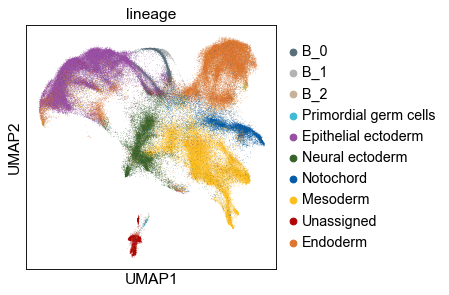

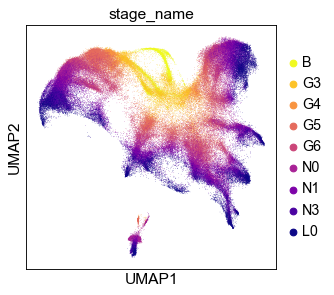

In [14]:
sc.settings.figdir = resdir
sc.set_figure_params(fontsize=14)

lin_colors = pd.read_csv(
    DATADIR / 'lineage_colors.csv', index_col=0).iloc[:, 0]
adata.obs['lineage'] = pd.Categorical(
    adata.obs['lineage'], categories=lin_colors.index)
adata.uns['lineage_colors'] = lin_colors.tolist()
sc.pl.umap(adata, color='lineage', ncols=1, save='_lineage.pdf')
sc.pl.umap(adata, color='stage_name', palette='plasma_r', save='_stage.pdf')

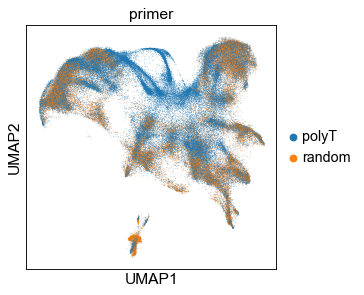

In [15]:
sc.pl.umap(adata, color='primer', save='_batch.pdf')

connecting stage B and G3
---> aggregating edges...
unique labels of rows: ['B_0' 'B_1' 'B_2']
unique labels of columns: ['G3_1' 'G3_0' 'G3_2' 'G3_3' 'G3_4' 'G3_5']
grouping elements (edges)
shape of the one-hot-labels: (7919, 3) (9385, 6)
parent nodes that had no descendent: ['B_2']
Taking descendant-points from other nodes (groups)
pasting stage labels
---> aggregating edges...
unique labels of rows: ['B_0' 'B_1' 'B_2']
unique labels of columns: ['G3_1' 'G3_0' 'G3_2' 'G3_3' 'G3_4' 'G3_5' 'G3_6']
grouping elements (edges)
shape of the one-hot-labels: (7919, 3) (9385, 7)

connecting stage G3 and G4
---> aggregating edges...
unique labels of rows: ['G3_0', 'G3_1', 'G3_2', 'G3_3', 'G3_4', 'G3_5', 'G3_6']
unique labels of columns: ['G4_3' 'G4_2' 'G4_0' 'G4_4' 'G4_1']
grouping elements (edges)
shape of the one-hot-labels: (9385, 7) (7508, 5)
parent nodes that had no descendent: ['G3_3', 'G3_6']
Taking descendant-points from other nodes (groups)
pasting stage labels
---> aggregating edges..

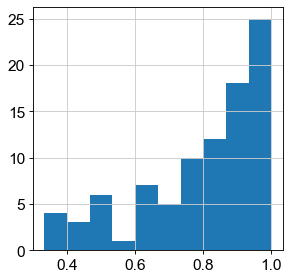

In [16]:
from scipy import sparse
obs = adata.obs
group_lbs = obs['stagewise_cluster'].values
stage_lbs = obs['stage_name'].values
KEY_TREE_NODE = 'tree_node'

# graph to tree
conn_upper = sparse.triu(connect).tocsc()
adj_max = swnn.max_connection(conn_upper)
edgedf, new_group_lbs = swnn.adaptive_tree(
    adj_max, group_lbs, stage_lbs=stage_lbs, stage_ord=stage_order)

obs[KEY_TREE_NODE] = new_group_lbs
edgedf.prop.hist() # voting proportions
logging.info("edgedf = %s", edgedf)

df_tree = edgedf[['node', 'parent']].copy()
df_tree['label'] = df_tree['node'].copy()
df_tree['stage'] = df_tree['node'].apply(lambda x: x.split('_')[0])
groupby = KEY_TREE_NODE
props_all = swnn.group_mean_adata(adata, groupby, use_raw=True, binary=True)
means_all = swnn.group_mean_adata(adata, groupby, use_raw=True, )


In [17]:
props_all.to_csv(resdir / f'expr_prop_all.csv', index=True, header=True)
means_all.to_csv(resdir / f'avg_expr_all.csv', index=True, header=True)